<a href="https://colab.research.google.com/github/armanabtahi/CPSC340-2021W2/blob/main/CPSC532S_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

In [2]:
from collections import defaultdict
from IPython import display
from PIL import Image
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms

import json
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Data Acquisition

For this assignment, you must download the dataset provided as a separate link on the course webpage and extract it into `data/`. The dataset contains approximately 20K training images and 100 validation images, with multiple captions/tags for each image. For this assignment, we are only concerned with the tags and ignore the captions.

For question two on the assignment, the dataset also contains a JSON file that maps from the ImageNet labels to the category names. 

Following the data downloading and unzipping, the code below loads in the data into memory accordingly.

In [4]:
# libraries for the files in google drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Colab_Notebooks/Multimodal_Learning/data/data.zip;

In [13]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    # image = Image.open(filename).convert('RGB')
    # image_tensor = loader(image).float()
    # image_var = Variable(image_tensor).unsqueeze(0)
    #return image_var


    return Variable(loader(Image.open(filename).convert('RGB')).float()).unsqueeze(0)
    #return image_var.cuda()

load_image('data_sampled/train2014/COCO_train2014_000000000009.jpg')

tensor([[[[0.0039, 0.0078, 0.0039,  ..., 0.0471, 0.0471, 0.0314],
          [0.0039, 0.0039, 0.0039,  ..., 0.0353, 0.0353, 0.0392],
          [0.0039, 0.0039, 0.0039,  ..., 0.0392, 0.0392, 0.0510],
          ...,
          [0.7137, 0.7294, 0.7137,  ..., 0.1686, 0.1843, 0.1686],
          [0.7059, 0.6902, 0.6863,  ..., 0.1765, 0.1804, 0.2039],
          [0.6784, 0.6667, 0.6706,  ..., 0.1922, 0.2157, 0.2275]],

         [[0.1490, 0.1490, 0.1412,  ..., 0.0039, 0.0039, 0.0039],
          [0.1451, 0.1412, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          [0.1412, 0.1373, 0.1373,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.4392, 0.4667, 0.4549,  ..., 0.2588, 0.2745, 0.2863],
          [0.4353, 0.4235, 0.4196,  ..., 0.2745, 0.2980, 0.3137],
          [0.4118, 0.4000, 0.4000,  ..., 0.3020, 0.3176, 0.3020]],

         [[0.5294, 0.5294, 0.5294,  ..., 0.1451, 0.1412, 0.1333],
          [0.5255, 0.5333, 0.5373,  ..., 0.1725, 0.1451, 0.1412],
          [0.5373, 0.5490, 0.5451,  ..., 0

In [14]:
# Load ImageNet label to category name mapping.
imagenet_categories = [value for key,value in sorted(json.load(open('data_sampled/imagenet_categories.json')).items(), key=lambda t: int(t[0]))]

# Load annotations file for the 20K training images.
mscoco_train = json.load(open('data_sampled/annotations/train2014.json'))
train_ids = [entry['id'] for entry in mscoco_train['images']]
train_id_to_file = {entry['id']: 'data_sampled/train2014/' + entry['file_name'] for entry in mscoco_train['images']}
category_to_name = {entry['id']: entry['name'] for entry in mscoco_train['categories']}
category_idx_to_name = [entry['name'] for entry in mscoco_train['categories']]
category_to_idx = {entry['id']: i for i,entry in enumerate(mscoco_train['categories'])}
idx_to_category = {value: key for key, value in category_to_idx.items()}

# Load annotations file for the 100 validation images.
mscoco_val = json.load(open('data_sampled/annotations/val2014.json'))
val_ids = [entry['id'] for entry in mscoco_val['images']]
val_id_to_file = {entry['id']: 'data_sampled/val2014/' + entry['file_name'] for entry in mscoco_val['images']}

# We extract out all of the category labels for the images in the training set. We use a set to ignore 
# duplicate labels.
train_id_to_categories = defaultdict(set)
for entry in mscoco_train['annotations']:
    train_id_to_categories[entry['image_id']].add(entry['category_id'])

# We extract out all of the category labels for the images in the validation set. We use a set to ignore 
# duplicate labels.
val_id_to_categories = defaultdict(set)
for entry in mscoco_val['annotations']:
    val_id_to_categories[entry['image_id']].add(entry['category_id'])

Let us take a look at an image and its corresponding category labels. We consider the image with the id 391895 and the corresponding filename, `data/val2014/COCO_val2014_000000391895.jpg`. The image is shown below.

![image](data/val2014/COCO_val2014_000000391895.jpg)

The following code determines the category labels for this image.

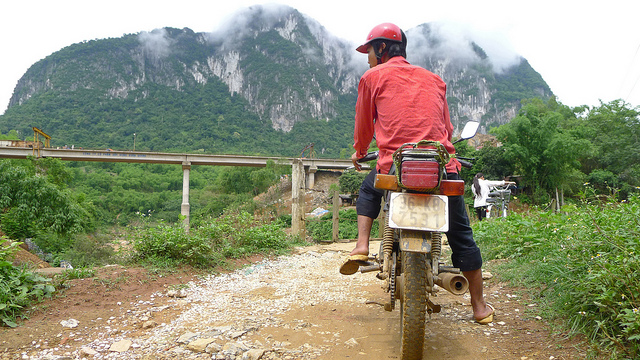

In [6]:
Image.open('data_sampled/val2014/COCO_val2014_000000391895.jpg')

In [10]:
for i,category in enumerate(val_id_to_categories[391895]):
    print("%d. %s" % (i, category_to_name[category]))

0. person
1. bicycle
2. motorcycle


# 1. Loading a Pre-trained Convolutional Neural Network (CNN)

We will work with the VGG-16 image classification CNN network first introduced in [Very Deep Convolutional Neural Networks for Large-Scale Image Recognition](https://arxiv.org/pdf/1409.1556.pdf) by K. Simonyan and A. Zisserman.

Fairly straightforwardly, we load the pre-trained VGG model and indicate to PyTorch that we are using the model for inference rather than training.

In [4]:
vgg_model = models.vgg16(pretrained=True)
vgg_model.eval()
#vgg_model.cuda()
# Let's see what the model looks like.
vgg_model

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 2. Making Predictions Using VGG-16

Given the pre-trained network, we must now write the code to make predictions on the 10 validation images via a forward pass through the network. Typically the final layer of VGG-16 is a softmax layer, however the pre-trained PyTorch model that we are using does not have softmax built into the final layer (instead opting to incorporate it into the loss function) and therefore we must **manually** apply softmax to the output of the function.

In [5]:
softmax = nn.Softmax()
for image_id in val_ids[:10]:
    # Display the image.
    # -- Your code goes here --
    plt.imshow(Image.open(val_id_to_file[image_id]))
    plt.show()

    # Print all of the category labels for this image.
    # -- Your code goes here --
    for i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))
  
    # Load/preprocess the image.
    img = load_image(val_id_to_file[image_id])

    # Run the image through the model and softmax.
    label_likelihoods = softmax(vgg_model(img)).squeeze()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions.
    for i in range(len(probs)):
        print('p(%s) = %f' % (imagenet_categories[indices[i]],probs[i]))
    # -- Your code goes here --

NameError: ignored

# 3. Computing Generic Visual Features using CNN

Since, rather than the output of VGG, we want a fixed sized vector representation of each image, we remove the last linear layer. The implementation of the forward function for VGG is shown below:

```
x = self.features(x)
x = x.view(x.size(0), -1)
x = self.classifier(x)
```
We aim to preserve everything but the final component of the classifier, meaning we must define an alternative equivalent to `self.classifier`.

In [6]:
# Remove the final layer of the classifier, and indicate to PyTorch that the model is being used for inference
# rather than training (most importantly, this disables dropout).
    
# -- Your code goes here --
vgg_model.classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-2]); # strips off last linear layer
# Let's see what the model looks like.
vgg_model.eval()
vgg_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [14]:
# First we vectorize all of the features of training images and write the results to a file.

# -- Your code goes here --

training_vectors={}
for image_id in train_ids:
    with torch.no_grad():
        training_vectors[ image_id]=  vgg_model(load_image(train_id_to_file[image_id]).to(device))   
np.save(open('outputs/training_vectors', 'wb+'), training_vectors)

In [15]:
# Next we vectorize all of the features of validation images and write the results to a file.
    
# -- Your code goes here --
validation_vectors={}
for image_id in val_ids:
    with torch.no_grad():
        validation_vectors [image_id]= vgg_model(load_image(val_id_to_file[image_id]).to(device))    
np.save(open('outputs/validation_vectors', 'wb+'), validation_vectors)

In [7]:
training_vectors = np.load(open('outputs/training_vectors', 'rb'), allow_pickle=True).item()
validation_vectors = np.load(open('outputs/validation_vectors', 'rb'), allow_pickle=True).item()

# 4. Visual Similarity

We now use the generated vectors, to find the closest training image for each validation image. This can easily be done by finding the training vector that minimizes the Euclidean distance for every validation image. We repeat this exercise for the first 10 images in the validation set.

In [18]:
# -- Your code goes here --
similarity_dict={}
for key_val, value_val in validation_vectors.items():
    dist=1000
    for key_train, value_train in training_vectors.items():
        dist2=torch.cdist(value_val,value_train)
        if dist2<dist:
            similarity_dict[key_val]=key_train
            dist=dist2

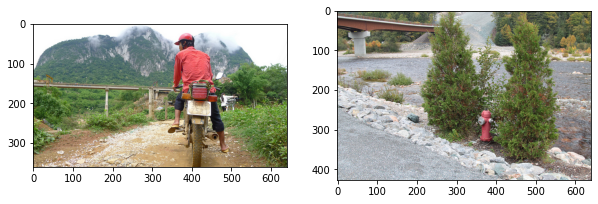

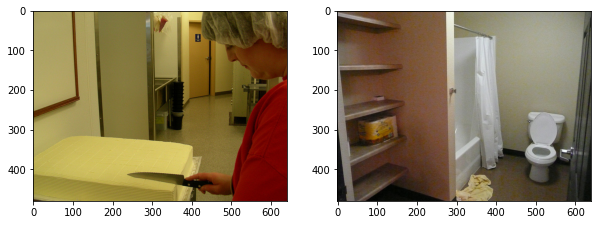

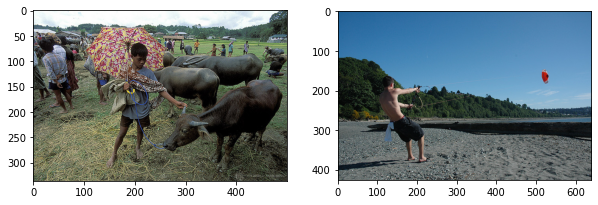

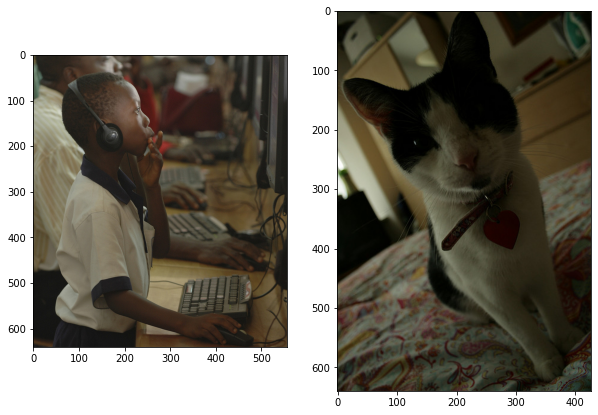

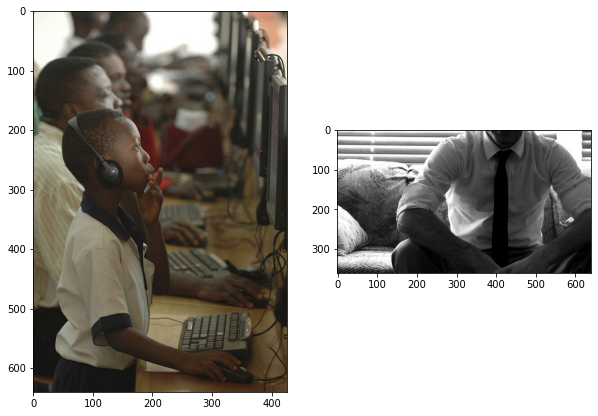

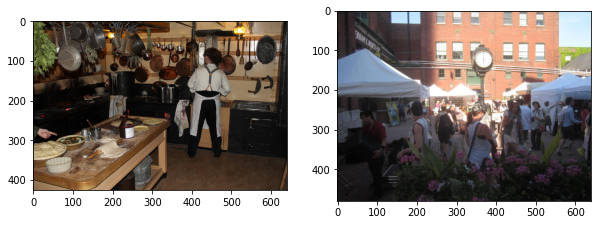

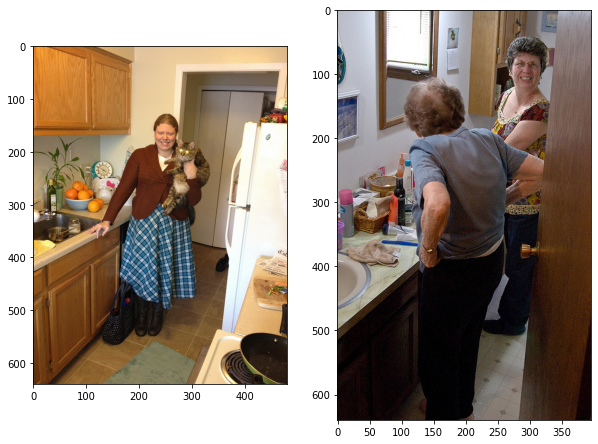

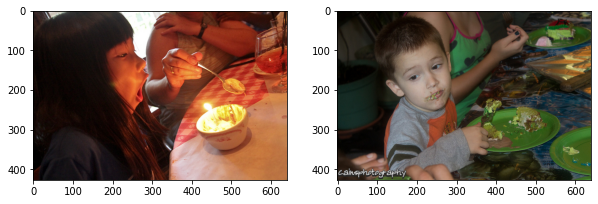

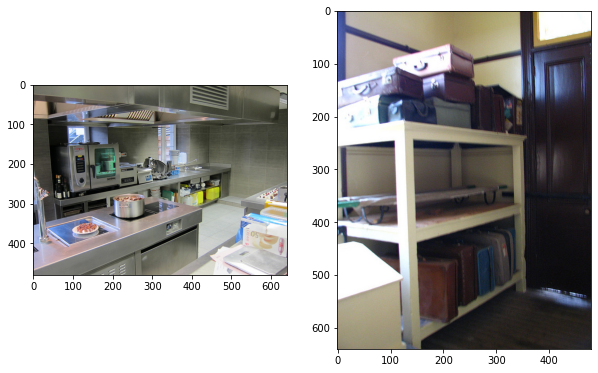

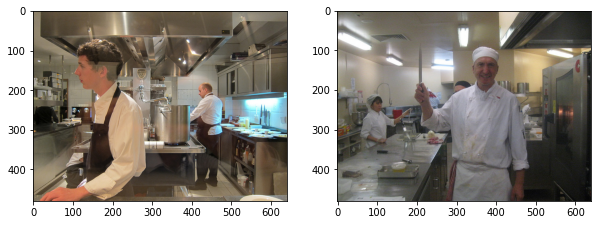

In [19]:
for v, t in list(similarity_dict.items())[:10]:
    fig = plt.figure(figsize=(10, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(Image.open(val_id_to_file[v]))
    fig.add_subplot(1, 2, 2)
    plt.imshow(Image.open(train_id_to_file[t]))

# 5. Training a Multi-Label Classification Network

We now build a two layer classification network, which takes 4096-dimensional vectors as input and outputs the probabilities of the 80 categories present in MSCOCO. 

For this purpose, we utilize two layers (both containing sigmoid activation functions) with the hidden dimension set to 512. 

In [8]:
import torch.optim as optim
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class CustomDataset(Dataset):
    def __init__(self, vectors,ids,id_to_categories,idx_to_category):
        self.ids = ids
        self.id_to_categories=id_to_categories
        self.vectors=vectors
        self.idx_to_category=idx_to_category

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        indices = self.id_to_categories[self.ids[idx]]
        label = torch.Tensor([[1 if self.idx_to_category[i] in indices else 0 for i in range(80)]])
        feat = self.vectors[self.ids[idx]]
        return feat, label.to(device)

In [10]:
# First we construct a class for the model
# -- Your code goes here --
class TwoLayerNN(nn.Module):
    def __init__(self):
        super(TwoLayerNN,self).__init__()

        self.linear1 = nn.Linear(4096, 512)
        self.linear2 = nn.Linear(512, 80)

    def forward(self,x):
        x = torch.sigmoid(self.linear1(x))
        #return torch.sigmoid(self.linear2(x))
        return self.linear2(x)


In [11]:
# The output data is prepared by representing each output as a binary vector of categories

def train(model,trainset,valset,loss_fn, optimizer,learning_rate, batch_size, epochs):
    """
    Training function which takes as input a model, a learning rate and a batch size.
  
    After completing a full pass over the data, the function exists, and the input model will be trained.
    """
    # -- Your code goes here --
    train_loader = torch.utils.data.DataLoader(dataset = trainset,
                                              batch_size = batch_size,
                                              shuffle = True)
    
    val_loader = torch.utils.data.DataLoader(dataset = valset,
                                            batch_size = batch_size,
                                            shuffle = False) # No need.

    N = epochs

    train_losses = []; val_losses = []

    model = model.to(device)
    loss_fn = loss_fn.to(device)

    for epoch in range(0, N):
        cum_loss = 0.0

        # Make a pass over the training data.
        model.train(True)
        for (i, (inputs, labels)) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            loss = loss_fn(scores, labels)

            # Count how many correct in this batch.
            cum_loss += loss.item()

            # Zero the gradients in the network.
            optimizer.zero_grad()

            #Backward pass. (Gradient computation stage)
            loss.backward()

            # Parameter updates (SGD step) -- if done with torch.optim!
            optimizer.step()

            # Parameter updates (SGD step) -- if done manually!
            # for param in model.parameters():
            #   param.data.add_(-learningRate, param.grad)

            # Logging the current results on training.
            if (i + 1) % 100 == 0:
                print('Train-epoch %d. Iteration %05d / %05d, Avg-Loss: %.4f' % 
                      (epoch, i + 1, len(train_loader), cum_loss / (i + 1)))

        train_losses.append(cum_loss / (i + 1))   

        # Make a pass over the validation data.
        cum_loss = 0.0
        model.eval()
        for (i, (inputs, labels)) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass. (Prediction stage)
            scores = model(inputs)
            cum_loss += loss_fn(scores, labels).item()

        val_losses.append(cum_loss / (i + 1))

        # Logging the current results on validation.
        print('Validation-epoch %d. Avg-Loss: %.4f' % 
              (epoch, cum_loss / (i + 1)))
    plt.figure()
    plt.plot(list(range(1, N+1)),train_losses,'r',label='training')
    plt.plot(list(range(1, N+1)),val_losses,'b',label='validation')
    plt.xlabel('epoch',)
    plt.ylabel('loss')
    plt.legend()
    plt.title('learning rate={:.4f} ,batch_size={:d}'.format(learning_rate, batch_size))


In [15]:
trainset=CustomDataset(training_vectors,train_ids,train_id_to_categories,idx_to_category)
valset=CustomDataset(validation_vectors,val_ids,val_id_to_categories,idx_to_category)
TwoLayerModel = TwoLayerNN()

Train-epoch 0. Iteration 00100 / 00200, Avg-Loss: 0.1486
Train-epoch 0. Iteration 00200 / 00200, Avg-Loss: 0.1301
Validation-epoch 0. Avg-Loss: 0.1229
Train-epoch 1. Iteration 00100 / 00200, Avg-Loss: 0.0994
Train-epoch 1. Iteration 00200 / 00200, Avg-Loss: 0.0949
Validation-epoch 1. Avg-Loss: 0.1068
Train-epoch 2. Iteration 00100 / 00200, Avg-Loss: 0.0852
Train-epoch 2. Iteration 00200 / 00200, Avg-Loss: 0.0838
Validation-epoch 2. Avg-Loss: 0.0995
Train-epoch 3. Iteration 00100 / 00200, Avg-Loss: 0.0789
Train-epoch 3. Iteration 00200 / 00200, Avg-Loss: 0.0778
Validation-epoch 3. Avg-Loss: 0.0959
Train-epoch 4. Iteration 00100 / 00200, Avg-Loss: 0.0741
Train-epoch 4. Iteration 00200 / 00200, Avg-Loss: 0.0738
Validation-epoch 4. Avg-Loss: 0.0946


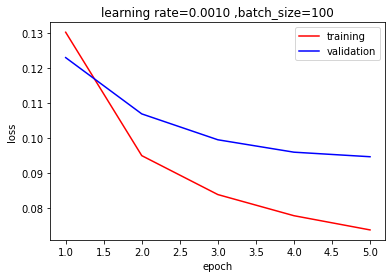

In [16]:
learning_rate=0.001
batch_size=100
epochs=5
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(TwoLayerModel.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-05)
train(TwoLayerModel,trainset,valset,loss_fn=loss_fn, optimizer=optimizer,learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

In [17]:
torch.save(TwoLayerModel.state_dict(), 'outputs/TwoLayerModel')

True labels
0. potted plant
1. dining table
2. book
3. vase
4. chair
Prdicted labels
p(chair) = 0.756110
p(dining table) = 0.404977
p(vase) = 0.333716
p(bowl) = 0.271866
p(bottle) = 0.233392


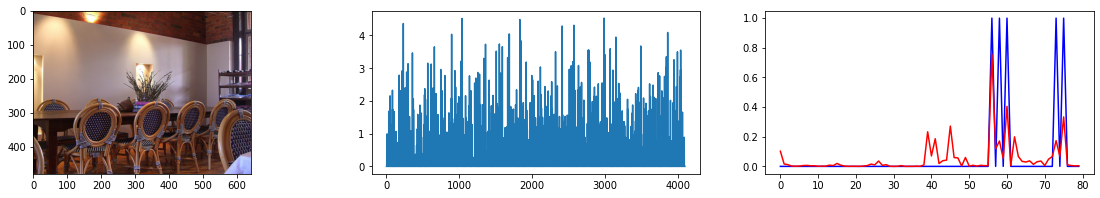

In [18]:
# see if it can overfit on 1 image
image_id=train_ids[0]
fig = plt.figure(figsize=(20, 3))
fig.add_subplot(1, 3, 1)
plt.imshow(Image.open(train_id_to_file[image_id]))
fig.add_subplot(1, 3, 2)
plt.plot(trainset[0][0].cpu().numpy()[0])
fig.add_subplot(1, 3, 3)
plt.plot(trainset[0][1][0].cpu().numpy(),'b')
plt.plot(torch.sigmoid(TwoLayerModel(trainset[0][0])).cpu().squeeze().detach().numpy(),'r')
print('True labels')
for i,category in enumerate(train_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))
print('Prdicted labels')
label_likelihoods = torch.sigmoid(TwoLayerModel(training_vectors[image_id])).squeeze()
probs, indices = label_likelihoods.topk(5)
for i in range(len(probs)):
    print('p(%s) = %f' % (category_to_name[idx_to_category[indices[i].item()]],probs[i]))

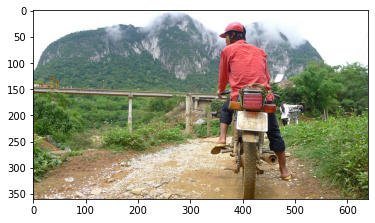

0. person
1. bicycle
2. motorcycle
p(person) = 0.956957
p(elephant) = 0.132417
p(horse) = 0.117075
p(bench) = 0.078693
p(car) = 0.078321


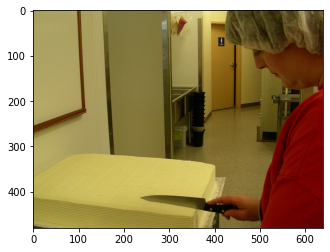

0. sink
1. person
2. cake
3. knife
p(person) = 0.575255
p(sink) = 0.266722
p(bed) = 0.252789
p(chair) = 0.199325
p(toilet) = 0.159662


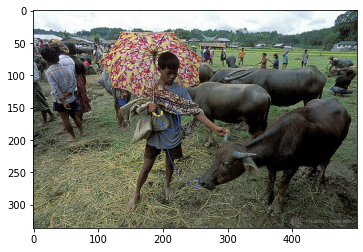

0. person
1. umbrella
2. cow
p(person) = 0.922196
p(horse) = 0.602501
p(giraffe) = 0.216030
p(cow) = 0.109841
p(umbrella) = 0.096591


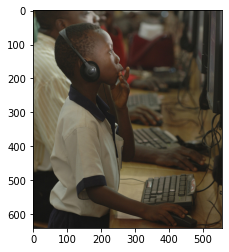

0. tv
1. person
2. mouse
3. keyboard
p(person) = 0.961628
p(handbag) = 0.228742
p(chair) = 0.181365
p(cell phone) = 0.169088
p(tie) = 0.119121


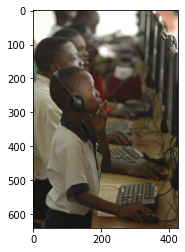

0. tv
1. person
2. mouse
3. keyboard
p(person) = 0.977840
p(handbag) = 0.228059
p(tie) = 0.220584
p(cell phone) = 0.136346
p(car) = 0.108373


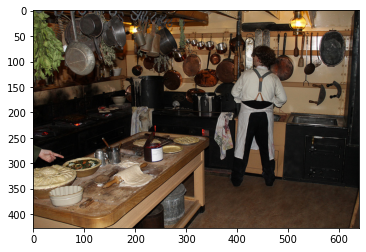

0. person
1. dining table
2. bottle
3. oven
4. cup
5. knife
6. spoon
7. bowl
8. sink
9. broccoli
10. carrot
p(chair) = 0.881585
p(dining table) = 0.857509
p(person) = 0.813695
p(bowl) = 0.514313
p(bottle) = 0.504013


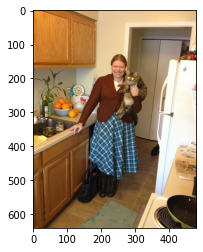

0. potted plant
1. person
2. bottle
3. oven
4. cat
5. refrigerator
6. spoon
7. bowl
8. clock
9. sink
10. orange
11. handbag
p(person) = 0.831256
p(sink) = 0.634965
p(bottle) = 0.628601
p(bowl) = 0.573043
p(refrigerator) = 0.502780


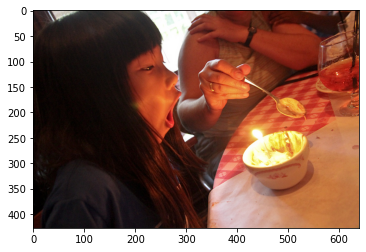

0. person
1. dining table
2. wine glass
3. spoon
4. bowl
p(person) = 0.981378
p(dining table) = 0.644190
p(pizza) = 0.292875
p(bowl) = 0.264199
p(fork) = 0.246958


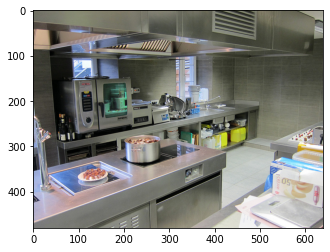

0. sink
1. bowl
2. bottle
3. oven
p(refrigerator) = 0.774253
p(oven) = 0.772003
p(bowl) = 0.588215
p(bottle) = 0.583685
p(sink) = 0.569039


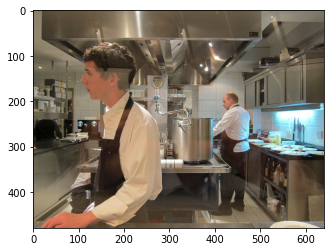

0. person
1. bottle
2. cup
3. knife
4. bowl
5. backpack
p(person) = 0.951919
p(bottle) = 0.537652
p(chair) = 0.433633
p(dining table) = 0.363659
p(bowl) = 0.350654


In [19]:
# Now repeat step two using the two layer classifier.
for image_id in val_ids[:10]:
    # Display the image.
    # -- Your code goes here --
    plt.imshow(Image.open(val_id_to_file[image_id]))
    plt.show()

    # Print all of the category labels for this image.
    # -- Your code goes here --
    for i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))
    

    # Run the image through the model and softmax.
    label_likelihoods = torch.sigmoid(TwoLayerModel(validation_vectors[image_id])).squeeze()

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions.
    for i in range(len(probs)):
        print('p(%s) = %f' % (category_to_name[idx_to_category[indices[i].item()]],probs[i]))

# 6. End-to-End Model Fine-tuning

Instead of training *only* the final two layers, we now create an end-to-end model and train the entire thing. 

In [20]:
# First we construct a class for the model
class StackedNN(nn.Module):
    def __init__(self, model1, model2):
        super(StackedNN, self).__init__()
        self.model1 = model1
        self.model2 = model2

    def forward(self, x):
        x = self.model1(x)
        x = self.model2(x)
        return x


In [21]:
class CustomDataset2(Dataset):
    def __init__(self, ids,id_to_file,id_to_categories,idx_to_category):
        self.ids = ids
        self.id_to_categories=id_to_categories
        self.id_to_file=id_to_file
        self.idx_to_category=idx_to_category

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        indices = self.id_to_categories[self.ids[idx]]
        label = torch.Tensor([[1 if self.idx_to_category[i] in indices else 0 for i in range(80)]])
        image = load_image(self.id_to_file[self.ids[idx]]).squeeze(0)
        return image, label

In [39]:
import copy
trainset2=CustomDataset2(train_ids,train_id_to_file,train_id_to_categories,idx_to_category)
valset2=CustomDataset2(val_ids,val_id_to_file,val_id_to_categories,idx_to_category)

deep_copy_vgg_model = copy.deepcopy(vgg_model)
deep_copy_TwoLayerModel = copy.deepcopy(TwoLayerModel)
StackedModel = StackedNN(deep_copy_vgg_model,deep_copy_TwoLayerModel)

Train-epoch 0. Iteration 00100 / 00625, Avg-Loss: 0.0771
Train-epoch 0. Iteration 00200 / 00625, Avg-Loss: 0.0759
Train-epoch 0. Iteration 00300 / 00625, Avg-Loss: 0.0754
Train-epoch 0. Iteration 00400 / 00625, Avg-Loss: 0.0745
Train-epoch 0. Iteration 00500 / 00625, Avg-Loss: 0.0738
Train-epoch 0. Iteration 00600 / 00625, Avg-Loss: 0.0732
Validation-epoch 0. Avg-Loss: 0.0543
Train-epoch 1. Iteration 00100 / 00625, Avg-Loss: 0.0674
Train-epoch 1. Iteration 00200 / 00625, Avg-Loss: 0.0664
Train-epoch 1. Iteration 00300 / 00625, Avg-Loss: 0.0658
Train-epoch 1. Iteration 00400 / 00625, Avg-Loss: 0.0653
Train-epoch 1. Iteration 00500 / 00625, Avg-Loss: 0.0647
Train-epoch 1. Iteration 00600 / 00625, Avg-Loss: 0.0640
Validation-epoch 1. Avg-Loss: 0.0500


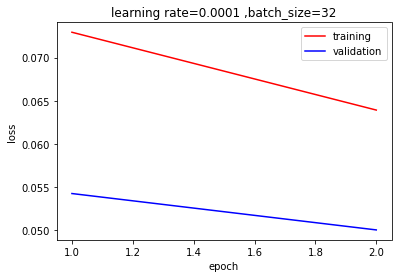

In [36]:
learning_rate=0.0001
batch_size=32
epochs=2
loss_fn = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(StackedModel.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-05)
train(StackedModel,trainset2,valset2,loss_fn=loss_fn, optimizer=optimizer,learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
StackedModel.eval();

In [42]:
torch.save(StackedModel.state_dict(), 'outputs/StackedModel')

True labels
0. potted plant
1. dining table
2. book
3. vase
4. chair
Prdicted labels
p(chair) = 0.756110
p(dining table) = 0.404977
p(vase) = 0.333716
p(bowl) = 0.271866
p(bottle) = 0.233392


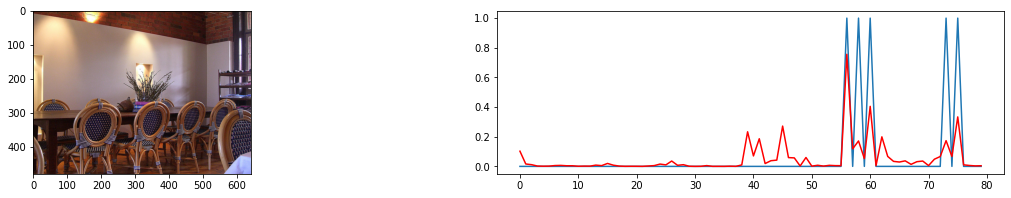

In [40]:

# see if it can overfit on 1 image
image_id=train_ids[0]
fig = plt.figure(figsize=(20, 3))
fig.add_subplot(1, 2, 1)
plt.imshow(Image.open(train_id_to_file[image_id]))
fig.add_subplot(1, 2, 2)
plt.plot(trainset2[0][1][0].cpu().numpy())
plt.plot(torch.sigmoid(StackedModel(trainset2[0][0].unsqueeze(0).to(device))).detach().squeeze().cpu().numpy(),'r')
print('True labels')
for i,category in enumerate(train_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))
print('Prdicted labels')
label_likelihoods = torch.sigmoid(StackedModel(load_image(train_id_to_file[image_id]).to(device)).detach().squeeze())
probs, indices = label_likelihoods.topk(5)
for i in range(len(probs)):
    print('p(%s) = %f' % (category_to_name[idx_to_category[indices[i].item()]],probs[i]))

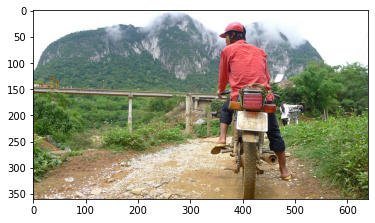

0. person
1. bicycle
2. motorcycle
p(person) = 0.956957
p(elephant) = 0.132417
p(horse) = 0.117075
p(bench) = 0.078693
p(car) = 0.078321


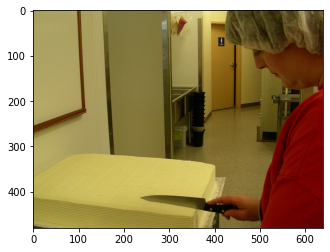

0. sink
1. person
2. cake
3. knife
p(person) = 0.575255
p(sink) = 0.266722
p(bed) = 0.252789
p(chair) = 0.199325
p(toilet) = 0.159662


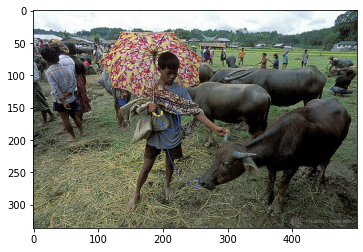

0. person
1. umbrella
2. cow
p(person) = 0.922196
p(horse) = 0.602501
p(giraffe) = 0.216030
p(cow) = 0.109841
p(umbrella) = 0.096591


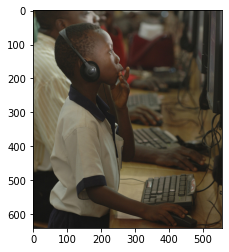

0. tv
1. person
2. mouse
3. keyboard
p(person) = 0.961628
p(handbag) = 0.228742
p(chair) = 0.181365
p(cell phone) = 0.169088
p(tie) = 0.119121


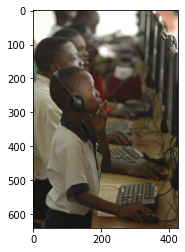

0. tv
1. person
2. mouse
3. keyboard
p(person) = 0.977840
p(handbag) = 0.228059
p(tie) = 0.220584
p(cell phone) = 0.136346
p(car) = 0.108373


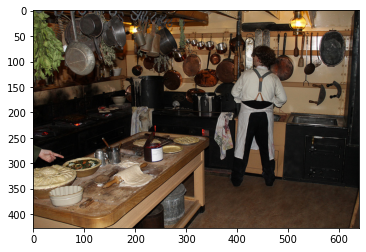

0. person
1. dining table
2. bottle
3. oven
4. cup
5. knife
6. spoon
7. bowl
8. sink
9. broccoli
10. carrot
p(chair) = 0.881585
p(dining table) = 0.857509
p(person) = 0.813695
p(bowl) = 0.514313
p(bottle) = 0.504013


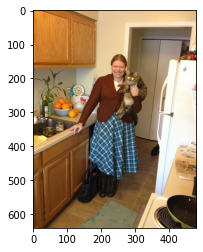

0. potted plant
1. person
2. bottle
3. oven
4. cat
5. refrigerator
6. spoon
7. bowl
8. clock
9. sink
10. orange
11. handbag
p(person) = 0.831256
p(sink) = 0.634965
p(bottle) = 0.628601
p(bowl) = 0.573043
p(refrigerator) = 0.502780


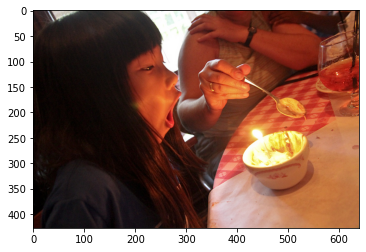

0. person
1. dining table
2. wine glass
3. spoon
4. bowl
p(person) = 0.981378
p(dining table) = 0.644190
p(pizza) = 0.292875
p(bowl) = 0.264199
p(fork) = 0.246958


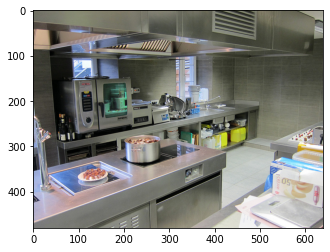

0. sink
1. bowl
2. bottle
3. oven
p(refrigerator) = 0.774253
p(oven) = 0.772003
p(bowl) = 0.588215
p(bottle) = 0.583685
p(sink) = 0.569039


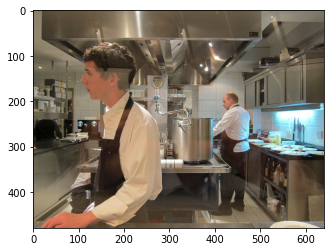

0. person
1. bottle
2. cup
3. knife
4. bowl
5. backpack
p(person) = 0.951919
p(bottle) = 0.537652
p(chair) = 0.433633
p(dining table) = 0.363659
p(bowl) = 0.350654


In [41]:
# Now repeat step two using the end-to-end classifier.
for image_id in val_ids[:10]:
    # Display the image.
    # -- Your code goes here --
    plt.imshow(Image.open(val_id_to_file[image_id]))
    plt.show()

    # Print all of the category labels for this image.
    # -- Your code goes here --
    for i,category in enumerate(val_id_to_categories[image_id]):
        print("%d. %s" % (i, category_to_name[category]))
  

    # Run the image through the model and softmax.
    label_likelihoods = torch.sigmoid(StackedModel(load_image(val_id_to_file[image_id]).to(device))).detach().squeeze()
    

    # Get the top 5 labels, and their corresponding likelihoods.
    probs, indices = label_likelihoods.topk(5)

    # Iterate and print out the predictions.
    for i in range(len(probs)):
        print('p(%s) = %f' % (category_to_name[idx_to_category[indices[i].item()]],probs[i]))

# 7. Hyper-parameter Tuning

Now we do a grid search over the learning rate and batch size.

In [ ]:
# -- Your code goes here --
LR=[0.00001,0.0001,0.001]#learning rate
BS=[32,64,128]#batch size

for learning_rate in LR:
    for batch_size in BS:
        epochs=2
        loss_fn = nn.MultiLabelSoftMarginLoss()
        deep_copy_vgg_model = copy.deepcopy(vgg_model)
        deep_copy_TwoLayerModel = copy.deepcopy(TwoLayerModel)
        StackedModel = StackedModels(deep_copy_vgg_model,deep_copy_TwoLayerModel)
        optimizer = optim.Adam(StackedModel.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-05)
        train(StackedModel,trainset2,valset2,loss_fn=loss_fn, optimizer=optimizer,learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 32, 1, 4096] to have 3 channels, but got 32 channels instead